# Performance evaluation and benchmarking

In this notebook we will go step-by-step through the model evaluation part of our paper, where we compare the predictions of the XGBoost and EA-LSTM models.

Note:
If you want to run this notebook locally and reproduce the figures of our paper
- make sure you have our pre-trained models. See the [README.md](link) in the repository for further instructions.

- make sure to have the CAMELS benchmark data set. See the [README.md](link) in the repository for further instructions.

#### Adapt the lines below according to your local system

In [1]:
# Needed if no precomputed results are used. Main directory containing all runs
BASE_RUN_DIR = "/home/mgauch/ealstm_regional_modeling/runs/run_grid_3010_2119/"

# Path to the main directory of this repository
BASE_CODE_DIR = "/home/mgauch/ealstm_regional_modeling"

In [2]:
# Imports
import pickle
import sys
from collections import defaultdict
from pathlib import Path
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from scipy.stats import wilcoxon

# Add repository to Python path
sys.path.append(BASE_CODE_DIR)
from papercode.plotutils import model_draw_style, model_specs_gridEvaluation, ecdf
from papercode.evalutils import (get_run_dirs_gridEvaluation, eval_datadriven_models, 
                                 eval_benchmark_models, get_pvals, 
                                 get_mean_basin_performance, get_cohens_d)
from papercode.metrics import *

Definition of global variables. 

**Note**: If you want to recompute all model metrics, change the `PRECOMPUTED_DATA` flag to `False`. No GPU is required. If you want to use the pre-calculated metrics, make sure the flag is set to `True`

In [3]:
# If True load pre-computed metrics from pickle file, else re-calculate everything
PRECOMPUTED_DATA = True

# Convert to PosixPaths
BASE_RUN_DIR = Path(BASE_RUN_DIR)

# Set of evaluation functions
EVAL_FUNCS = {'NSE': calc_nse, 
              'alpha_nse': calc_alpha_nse, 
              'beta_nse': calc_beta_nse,
              'FHV': calc_fdc_fhv, 
              'FLV': calc_fdc_flv, 
              'FMS': calc_fdc_fms}

# Evaluate data-driven models

First, we compare the XGBoost models with EA-LSTM models on different amounts of training data. There are nine different setups, resulting from the combinations of the following dimensions:

1. Number of training years: 3, 6, or 9
2. Number of basins: 13, 26, 53, 265, or 531

For each of the 3*5 settings, we trained 8 models (using different random initializations). We combined these 8 models to an ensemble (by averaging the k=8 model simulations), which is what we evaluate here.

To account for differences in the basins, we evaluate the performance on 13, 26, 53 and 265 basins on five different random basin subsets.

In [4]:
if PRECOMPUTED_DATA:
    print("Loaded data from pre-computed pickle file")
    with open(BASE_RUN_DIR / "all_metrics_gridEvaluation.p", "rb") as fp:
        all_metrics = pickle.load(fp)
else:
    all_metrics = {}
    for func_name, func in EVAL_FUNCS.items():
        tqdm.tqdm.write(f"Calculating metric: {func_name}")
        model_metrics = {}
        for model, training_years, n_basins in itertools.product(model_specs_gridEvaluation['models'], 
                                                                 model_specs_gridEvaluation['training_years'], 
                                                                 model_specs_gridEvaluation['n_basins']):
            if not model in model_metrics: 
                model_metrics[model] = {}
            if not training_years in model_metrics[model]:
                model_metrics[model][training_years] = {}
            tqdm.tqdm.write(f"Model: {model}, Training years: {training_years}, number of basins: {n_basins}")
            for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
                run_dirs = get_run_dirs_gridEvaluation(root_dir=BASE_RUN_DIR, model=model, basin_subset=basin_subset, training_years=training_years)
                model_metrics[model][training_years][basin_subset] = eval_datadriven_models(run_dirs=run_dirs, func=func)

        all_metrics[func_name] = model_metrics

Loaded data from pre-computed pickle file


## Tabular comparison

In a first step, we look at the mean, median NSE as well as the number of catastrophic failures. Catastrophic failures are defined as the number of basins, where the model has a NSE <= 0.
We calculate the mean of each of this three statistics over the model (n=8) model repetitions and the random basin samples and report the standard deviation here as well. The repetitions are denoted as `ensemble=False` in the table below.

In [5]:
data = []
for model, model_label, _ in model_specs_gridEvaluation['models']:
    for training_years, n_basins in itertools.product(model_specs_gridEvaluation['training_years'], 
                                                      model_specs_gridEvaluation['n_basins']):
        ensemble_nses = []
        means, medians, failures, mins, maxs = [], [], [], [], []
        for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
            models = all_metrics['NSE'][model][training_years][basin_subset]
            seeds = [k for k in models.keys() if "seed" in k]
            if len(seeds) == 0:
                print(f"No data for {model}, {training_years} years, {n_basins} basins (subset no. {basin_subset})")
                continue
            for seed in seeds:
                values = list(models[seed].values())
                mins.append(np.min(values))
                maxs.append(np.max(values))
                means.append(np.mean(values))
                medians.append(np.median(values))
                failures.append(len([v for v in values if v <= 0]))
            ensemble_nses += list(models["ensemble"].values())
            
        data_sing = {'model': model_label, 
                     'training_years': training_years,
                     'n_basins': n_basins,
                     'ensemble': False, 
                     'min': np.min(mins), 
                     'max': np.max(maxs), 
                     'mean': np.mean(means), 
                     'std_mean': np.std(means),
                     'median': np.mean(medians),
                     'std_median': np.std(medians),
                     'failures': np.sum(failures) / len(seeds),
                     'std_failures': np.std(failures)}
        data.append(data_sing)
        data_ensemble = {'model': model_label, 
                         'training_years': training_years,
                         'n_basins': n_basins,
                         'ensemble': True,
                         'min': np.min(ensemble_nses),
                         'max': np.max(ensemble_nses),
                         'mean': np.mean(ensemble_nses),
                         'median': np.median(ensemble_nses),
                         'failures': len([v for v in ensemble_nses if v <= 0]) }
        data.append(data_ensemble)

df = pd.DataFrame(data)
df = df.set_index(keys=["training_years", "n_basins", "ensemble", "model"])
df.sort_values(by=["training_years","n_basins", "ensemble", "model"], inplace=True)
df

failures       max      mean  \
training_years n_basins ensemble model                                   
3              13       False    EA-LSTM    10.500  0.596818  0.114757   
                                 XGBoost     1.125  0.621599  0.301178   
                        True     EA-LSTM     8.000  0.544058  0.147755   
                                 XGBoost     1.000  0.605091  0.306206   
               26       False    EA-LSTM     7.125  0.637282  0.264800   
                                 XGBoost     3.625  0.742831  0.348929   
                        True     EA-LSTM     1.000  0.562238  0.299730   
                                 XGBoost     3.000  0.734580  0.357131   
               53       False    EA-LSTM     3.750  0.832208  0.430060   
                                 XGBoost     5.125  0.807143  0.438127   
                        True     EA-LSTM     1.000  0.805019  0.462638   
                                 XGBoost     5.000  0.805987  0.444821   
               265      False    EA-LSTM    11.750  0.910680  0.562408   
                                 XGBoost    24.125  0.846713  0.500750   
                        True     EA-LSTM     2.000  0.899358  0.600707   
                                 XGBoost    24.000  0.843507  0.509154   
               531      False    EA-LSTM     2.500  0.920291  0.597223   
                                 XGBoost     8.000  0.873397  0.520881   
                        True     EA-LSTM     0.000  0.927415  0.636011   
                                 XGBoost     8.000  0.873458  0.528879   
6              13       False    EA-LSTM     0.750  0.757458  0.386905   
                                 XGBoost     2.750  0.749935  0.427680   
                        True     EA-LSTM     1.000  0.680722  0.418537   
                                 XGBoost     3.000  0.743535  0.435575   
               26       False    EA-LSTM     2.250  0.819527  0.476888   
                                 XGBoost     4.375  0.782179  0.446945   
                        True     EA-LSTM     1.000  0.805620  0.515597   
                                 XGBoost     4.000  0.775792  0.460361   
               53       False    EA-LSTM     1.750  0.891978  0.563458   
                                 XGBoost     3.500  0.863569  0.538368   
                        True     EA-LSTM     0.000  0.892949  0.594758   
                                 XGBoost     2.000  0.861374  0.546825   
               265      False    EA-LSTM     9.625  0.927027  0.636164   
                                 XGBoost    20.250  0.901775  0.568214   
                        True     EA-LSTM     6.000  0.942785  0.668031   
                                 XGBoost    18.000  0.901416  0.577949   
               531      False    EA-LSTM     3.500  0.931685  0.651181   
                                 XGBoost     5.375  0.906579  0.586254   
                        True     EA-LSTM     3.000  0.942158  0.684236   
                                 XGBoost     5.000  0.907671  0.595636   
9              13       False    EA-LSTM     0.250  0.811064  0.465839   
                                 XGBoost     2.000  0.782670  0.471406   
                        True     EA-LSTM     0.000  0.805370  0.496790   
                                 XGBoost     2.000  0.777658  0.479068   
               26       False    EA-LSTM     1.125  0.889975  0.539954   
                                 XGBoost     3.375  0.812857  0.499519   
                        True     EA-LSTM     1.000  0.892473  0.570534   
                                 XGBoost     3.000  0.806738  0.510096   
               53       False    EA-LSTM     1.125  0.910975  0.602126   
                                 XGBoost     3.250  0.893857  0.566804   
                        True     EA-LSTM     1.000  0.917522  0.632637   
                                 XGBoost     3.000  0.894185  0.576258   
               265      False    EA-LSTM     8

## Plot correlation between number of samples and NSE

- Green triangles represent XGBoost, orange triangles represent EA-LSTMs.
- the color shade represents the amount of basins. The darker the color, the more basins.
- The triangle orientation represents the amount of training years. Triangles facing down: 3 years, facing left: 6 years, facing up: 9 years.

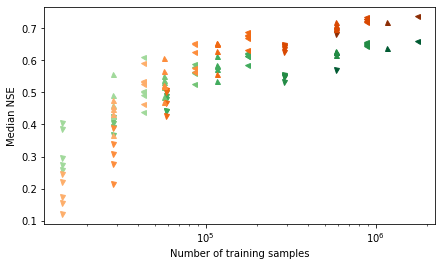

In [6]:
f = plt.figure(figsize=(7,4))

for model, name, color in model_specs_gridEvaluation["models"]:
    colors = {'xgboost': ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32'],
              'ealstm':  ['#fdae6b','#fd8d3c','#f16913','#d94801','#8c2d04']}
    markers = {3: "v", 6: "^", 9: "<"}
    
    for training_years, (i, n_basins) in itertools.product(model_specs_gridEvaluation['training_years'], 
                                                      enumerate(model_specs_gridEvaluation['n_basins'])):
        basin_subsets = model_specs_gridEvaluation["basin_subsets"][n_basins]
        median_nses, n_samples = [], []
        for b in basin_subsets:
            median_nses.append(np.median(list(all_metrics['NSE'][model][training_years][b]["ensemble"].values())))
            n_samples.append(training_years * 365 * n_basins)
        plt.plot(n_samples, median_nses, label=f"{name}, {training_years} years, {n_basins} basins", 
                 lw=0, marker=markers[training_years], c=colors[model][i], markersize=5)
    
plt.xscale('log')
plt.ylabel('Median NSE')
_ = plt.xlabel('Number of training samples')

## Calculate statistical significance.

Calculate statistical significance between XGBoost and EA-LSTM.

In [7]:
p_values = {}
d_values = {}
for training_years in model_specs_gridEvaluation['training_years']:
    p_values[training_years] = {}
    d_values[training_years] = {}
    for n_basins in model_specs_gridEvaluation['n_basins']:
        print(f"{training_years} training years, {n_basins} basins")
        
        basin_subsets = model_specs_gridEvaluation["basin_subsets"][n_basins]
        xgb_nses = list(all_metrics['NSE']["xgboost"][training_years][s]["ensemble"].values() for s in basin_subsets)
        xgb_nses = [y for x in xgb_nses for y in x]  # flatten
        ealstm_nses = list(all_metrics['NSE']["ealstm"][training_years][s]["ensemble"].values() for s in basin_subsets)
        ealstm_nses = [y for x in ealstm_nses for y in x]  # flatten
        
        _, p_val_ensemble = wilcoxon(xgb_nses, ealstm_nses)
        print(f"For ensemble mean {p_val_ensemble:.2e}")
        
        d_ensemble = get_cohens_d(xgb_nses, ealstm_nses)
        print(f"Effect size: Ensemble mean d={d_ensemble:.3f}")
        
        p_values[training_years][n_basins] = p_val_ensemble
        d_values[training_years][n_basins] = d_ensemble

3 training years, 13 basins
For ensemble mean 1.06e-09
Effect size: Ensemble mean d=1.010
3 training years, 26 basins
For ensemble mean 3.76e-10
Effect size: Ensemble mean d=0.262
3 training years, 53 basins
For ensemble mean 3.35e-03
Effect size: Ensemble mean d=0.101
3 training years, 265 basins
For ensemble mean 6.88e-154
Effect size: Ensemble mean d=0.457
3 training years, 531 basins
For ensemble mean 2.26e-73
Effect size: Ensemble mean d=0.579
6 training years, 13 basins
For ensemble mean 2.02e-02
Effect size: Ensemble mean d=0.099
6 training years, 26 basins
For ensemble mean 4.34e-03
Effect size: Ensemble mean d=0.169
6 training years, 53 basins
For ensemble mean 1.89e-17
Effect size: Ensemble mean d=0.287
6 training years, 265 basins
For ensemble mean 5.72e-153
Effect size: Ensemble mean d=0.424
6 training years, 531 basins
For ensemble mean 5.78e-70
Effect size: Ensemble mean d=0.463
9 training years, 13 basins
For ensemble mean 4.58e-01
Effect size: Ensemble mean d=0.110
9 tr

## Cumulative density function plot

Here we look at the CDF of the NSEs for each of our 3*5 configurations.

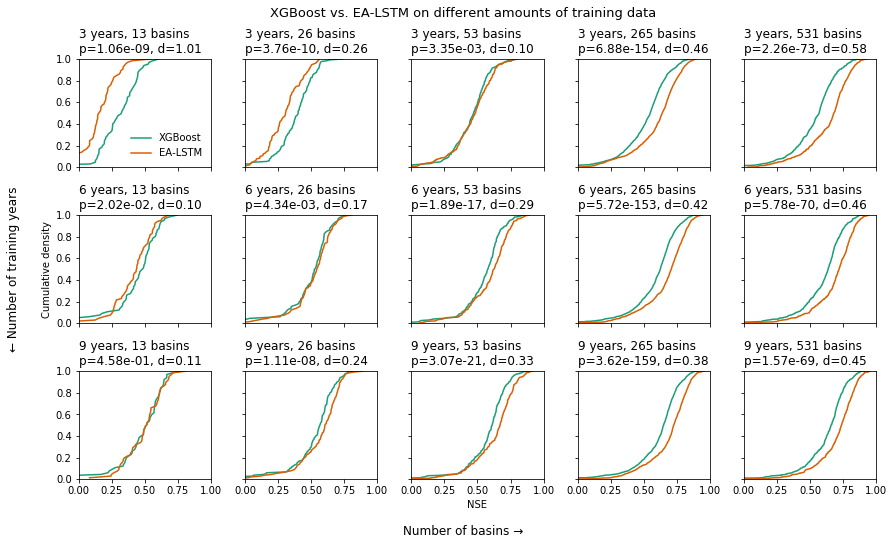

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(12,7))

for i, training_years in enumerate(model_specs_gridEvaluation['training_years']):
    for j, n_basins in enumerate(model_specs_gridEvaluation['n_basins']):
        ax[i,j].set_xlim(0, 1)
        ax[i,j].set_ylim(0, 1)
        
        for model, model_label, model_color in model_specs_gridEvaluation['models']:
            values = []
            for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
                values += list(all_metrics["NSE"][model][training_years][basin_subset]['ensemble'].values())
            bin_, cdf_ = ecdf(values)
            ax[i,j].plot(bin_, cdf_,
                         label=model_label, color=model_color)
            p_val = p_values[training_years][n_basins]
            d_val = d_values[training_years][n_basins]
            ax[i,j].set_title(f"{training_years} years, {n_basins} basins \np={p_val:.2e}, d={d_val:.2f}", loc='left', fontsize=12, fontweight=0)
ax[0,0].legend(loc="lower right", frameon=False)
ax[2,2].set_xlabel('NSE')
ax[1,0].set_ylabel('Cumulative density')
fig.text(0.5, -0.02, 'Number of basins →', ha='center', va='center', fontsize=12)
fig.text(-0.02, 0.5, '← Number of training years', ha='center', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()
_ = plt.suptitle("XGBoost vs. EA-LSTM on different amounts of training data", fontsize=13, fontweight=0, color='black', y=1.02)

In [9]:
if not PRECOMPUTED_DATA:
    with open(BASE_RUN_DIR / "all_metrics_gridEvaluation.p", "wb") as fp:
        pickle.dump(all_metrics, fp)
    print("Stored precomputed data in 'all_metrics_gridEvaluation.p'")

In [10]:
data = []
for model, model_label, _ in model_specs_gridEvaluation["models"]:
    for training_years, n_basins in itertools.product(model_specs_gridEvaluation['training_years'],
                                                      model_specs_gridEvaluation['n_basins']):
        for basin_subset in model_specs_gridEvaluation['basin_subsets'][n_basins]:
            single_model = {'model': model_label, 'ensemble': False,
                            'training_years': training_years,
                            'n_basins': n_basins,
                            'basin_subset': basin_subset}
            ensemble_mean = {'model': model_label, 'ensemble': True,
                             'training_years': training_years,
                             'n_basins': n_basins,
                             'basin_subset': basin_subset}
            # average over single models
            for metric, metric_data in all_metrics.items():
                seeds = [k for k in metric_data[model][training_years][basin_subset].keys() if "seed" in k]
                seed_vals = defaultdict(list)
                for seed in seeds:
                    values = list(metric_data[model][training_years][basin_subset][seed].values())
                    seed_vals[f"{metric} median"].append(np.median(values))
                    if metric == "NSE":
                        seed_vals[f"{metric} mean"].append(np.mean(values))
                        seed_vals["failures"].append(len([v for v in values if v <= 0]))
                    single_model[f"{metric} median"] = np.mean(seed_vals[f"{metric} median"])
                    single_model[f"{metric} median std"] = np.std(seed_vals[f"{metric} median"])
                    if metric == "NSE":
                        single_model[f"{metric} mean"] = np.mean(seed_vals[f"{metric} mean"])
                        single_model[f"{metric} mean std"] = np.std(seed_vals[f"{metric} mean"])
                        single_model[f"failures"] = np.mean(seed_vals["failures"])
                        single_model[f"failures std"] = np.std(seed_vals["failures"])

                # ensemble mean
                values = list(metric_data[model][training_years][basin_subset]["ensemble"].values())
                ensemble_mean[f"{metric} median"] = np.median(values)
                if metric == "NSE":
                    ensemble_mean["NSE mean"] = np.mean(values)
                    ensemble_mean["failures"] = len([v for v in values if v <= 0])
            data.append(single_model)
            data.append(ensemble_mean)
        
df = pd.DataFrame(data)
df = df.set_index(keys=["training_years", "n_basins", "basin_subset", "ensemble", "model"])
df.sort_values(["training_years", "n_basins", "basin_subset", "ensemble", "model"], inplace=True)
df

FHV median  \
training_years n_basins basin_subset ensemble model                 
3              13       16           False    EA-LSTM  -74.724322   
                                              XGBoost  -66.462193   
                                     True     EA-LSTM  -76.132173   
                                              XGBoost  -66.616092   
                        17           False    EA-LSTM  -81.252032   
                                              XGBoost  -66.228046   
                                     True     EA-LSTM  -83.224881   
                                              XGBoost  -66.710682   
                        18           False    EA-LSTM  -76.220268   
                                              XGBoost  -63.202173   
                                     True     EA-LSTM  -76.485334   
                                              XGBoost  -64.319971   
                        19           False    EA-LSTM  -74.480083   
                                              XGBoost  -60.041835   
                                     True     EA-LSTM  -76.745154   
                                              XGBoost  -60.882933   
                        20           False    EA-LSTM  -77.518858   
                                              XGBoost  -55.320312   
                                     True     EA-LSTM  -79.238823   
                                              XGBoost  -56.211224   
               26       11           False    EA-LSTM  -63.998624   
                                              XGBoost  -55.185761   
                                     True     EA-LSTM  -64.926029   
                                              XGBoost  -55.896249   
                        12           False    EA-LSTM  -52.023631   
                                              XGBoost  -50.592492   
                                     True     EA-LSTM  -54.669438   
                                              XGBoost  -51.107923   
                        13           False    EA-LSTM  -61.901890   
                                              XGBoost  -56.254720   
...                                                           ...   
9              53       9            True     EA-LSTM  -25.243888   
                                              XGBoost  -32.919632   
                        10           False    EA-LSTM  -23.218034   
                                              XGBoost  -32.686641   
                                     True     EA-LSTM  -24.593847   
                                              XGBoost  -32.681354   
               265      1            False    EA-LSTM  -18.213230   
                                              XGBoost  -28.217594   
                                     True     EA-LSTM  -19.190300   
                                              XGBoost  -28.524719   
                        2            False    EA-LSTM  -18.589298   
                                              XGBoost  -27.974459   
                                     True     EA-LSTM  -19.303852   
                                              XGBoost  -28.331430   
                        3            False    EA-LSTM  -15.979744   
                                              XGBoost  -26.519468   
                                     True     EA-LSTM  -17.948238   
                                              XGBoost  -26.509073   
                        4            False    EA-LSTM  -18.667094   
                                              XGBoost  -28.426055   
                                     True     EA-LSTM  -19.927106   
                                              XGBoost  -28.455486   
                        5            False    EA-LSTM  -16.816815   
                                              XGBoost  -27.535254   
                                     True     EA-LSTM  -17.837878   
                                              XGBoost